In [ ]:
!pip install qiskit
!pip install qiskit_machine_learning
!pip install qiskit_algorithm
!pip install pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.8/97.8 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.6/308.6 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512615 sha256=d1792677b914654bf6a96fd9f58f4be078e16552394ef0abaf140d5ff2fa3d4b
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448dab7

In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes, EfficientSU2, TwoLocal
from qiskit_machine_learning.algorithms import VQC
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
from qiskit.primitives import Sampler
import time

In [2]:
wine = load_wine()

X, Y = wine['data'], wine['target']

X_scaled = StandardScaler().fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

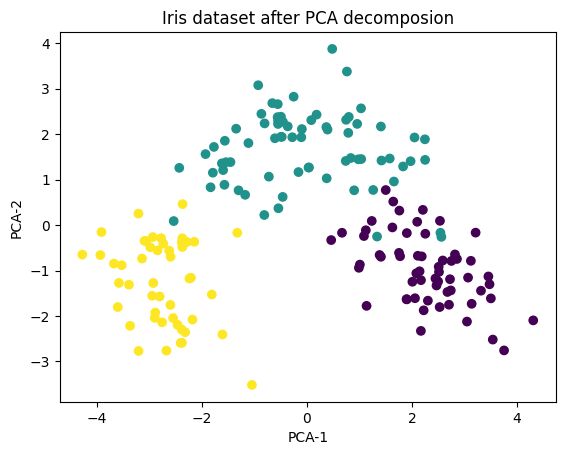

In [3]:
pca = PCA(n_components=2).fit_transform(X_scaled)

plt.scatter(pca[:,0], pca[:,1], c=Y)
plt.title('Iris dataset after PCA decomposion')
plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.show()

# **ZZFeatureMap RealAmplitudes**

In [4]:
MAXITR = 100
num_qubits = X.shape[1]
opt = COBYLA(maxiter=MAXITR)

In [5]:
featuremap = ZZFeatureMap(feature_dimension=num_qubits, reps=1, parameter_prefix='x')
ansatz = RealAmplitudes(num_qubits=num_qubits, reps=1)

/usr/local/lib/python3.10/dist-packages/qiskit/visualization/circuit/matplotlib.py:269: UserWarning: Style JSON file 'ixq.json' not found in any of these locations: /usr/local/lib/python3.10/dist-packages/qiskit/visualization/circuit/styles/ixq.json, ixq.json. Will use default style.
  self._style, def_font_ratio = load_style(self._style)


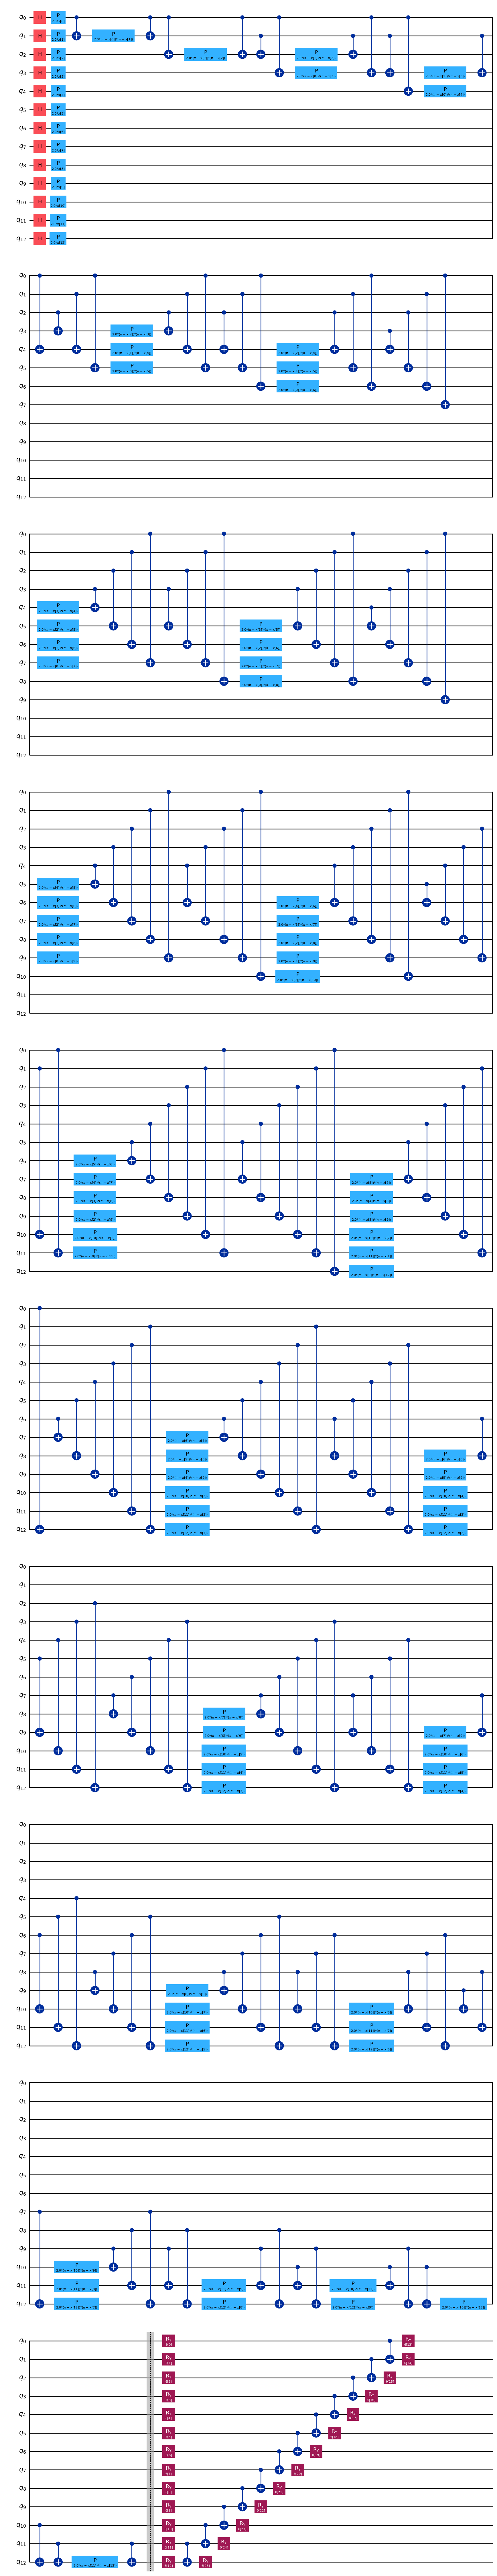

In [ ]:
qc = QuantumCircuit(num_qubits)
qc.compose(featuremap, inplace=True)
qc.barrier()
qc.compose(ansatz, inplace=True)
qc.decompose().draw(output='mpl', style='ixq')

In [6]:
objective_func_vals = []

def callback_graph(weights, obj_func_eval):
  clear_output(wait=True)
  objective_func_vals.append(obj_func_eval)
  plt.title("Objective function value against iteration")
  plt.xlabel("Iteration")
  plt.ylabel("Objective function value")
  plt.plot(range(len(objective_func_vals)), objective_func_vals)
  plt.show()

In [7]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []

In [8]:
vqc = VQC(
    feature_map=featuremap,
    ansatz=ansatz,
    optimizer=opt,
    callback=callback_graph,
)

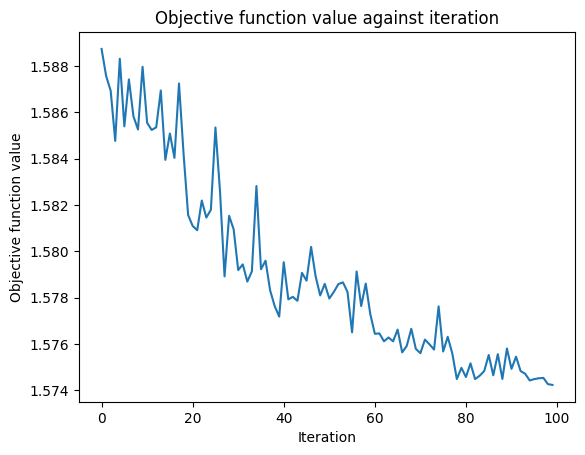

In [9]:
start = time.time()
vqc.fit(X_train, Y_train)
elapsed = time.time() - start

In [10]:
preds = vqc.predict(X_test)
score = vqc.score(X_test, Y_test)
precision = precision_score(Y_test, preds, average='weighted')
accuracy = accuracy_score(Y_test, preds)
recall = recall_score(Y_test, preds, average='weighted')
f1 = f1_score(Y_test, preds, average='weighted')

In [11]:
times.append(elapsed)
precisions.append(precision)
accuracies.append(accuracy)
recalls.append(recall)
f1s.append(f1)

In [12]:
print("Precision:\n",precisions)
print("Accuracy:\n",accuracies)
print("Recall:\n",recalls)
print("F1:\n",f1s)
print("Time:\n",times)

Precision:
 [0.48465423465423463]
Accuracy:
 [0.4722222222222222]
Recall:
 [0.4722222222222222]
F1:
 [0.47470052148414726]
Time:
 [2189.4327788352966]


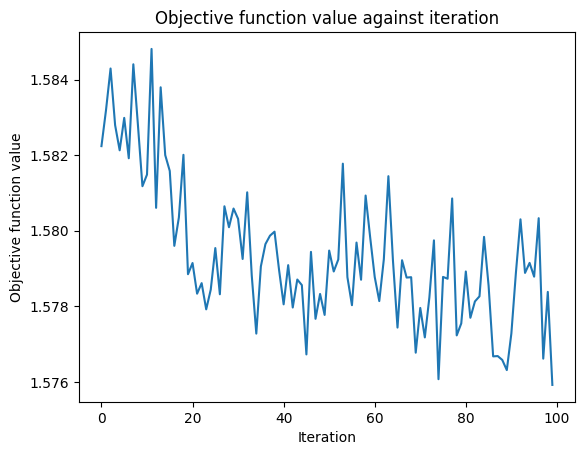

Time:
 [2189.4327788352966, 2440.116142511368]
Precision:
 [0.48465423465423463, 0.36467236467236464]
Accuracy:
 [0.4722222222222222, 0.3611111111111111]
Recalls:
 [0.4722222222222222, 0.3611111111111111]
F1:
 [0.47470052148414726, 0.3527720266850702]


In [13]:
for i in range(1):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)


  MAXITR = 100
  num_qubits = X.shape[1]
  opt = COBYLA(maxiter=MAXITR)

  featuremap = ZZFeatureMap(feature_dimension=num_qubits, reps=1, parameter_prefix='x')
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=8)



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  score = vqc.score(X_test, Y_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='weighted')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Time:\n",times)
  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)

# **EfficientSU2 RealAmplitude**

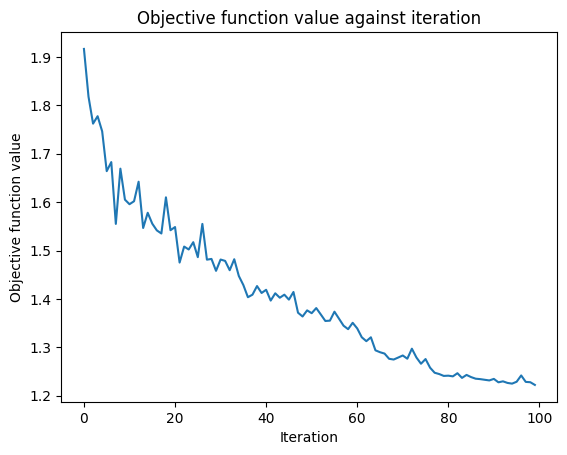

Precision:
 [0.6214424951267056, 0.7377104377104378, 0.700925925925926, 0.8037037037037037, 0.8164983164983164, 0.8213675213675214, 0.7646335146335147, 0.7377104377104378, 0.7453703703703703, 0.7250000000000001]
Accuracy:
 [0.6388888888888888, 0.7222222222222222, 0.6944444444444444, 0.7777777777777778, 0.8055555555555556, 0.8055555555555556, 0.75, 0.7222222222222222, 0.7222222222222222, 0.7222222222222222]
Recall:
 [0.5654761904761905, 0.7440476190476191, 0.6309523809523809, 0.8095238095238096, 0.8333333333333334, 0.7976190476190476, 0.7678571428571429, 0.7440476190476191, 0.6547619047619048, 0.7440476190476191]
F1:
 [0.5987228607918264, 0.7180211064058614, 0.6776437070554718, 0.7749999999999999, 0.8036611323967646, 0.8106995884773662, 0.7509538328251779, 0.7180211064058614, 0.6987567987567989, 0.7198480531813866]
Time:
 [44.73607587814331, 45.182942628860474, 45.09380078315735, 44.72313833236694, 45.28283071517944, 44.89192199707031, 44.825681924819946, 45.16391682624817, 44.833934307

In [14]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 100
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=1)



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)


**Precision:**
 [0.6214424951267056, 0.7377104377104378, 0.700925925925926, 0.8037037037037037, 0.8164983164983164, 0.8213675213675214, 0.7646335146335147, 0.7377104377104378, 0.7453703703703703, 0.7250000000000001]
**Mean Precision**
0.7474362723046933±0.057

**Accuracy:**
 [0.6388888888888888, 0.7222222222222222, 0.6944444444444444, 0.7777777777777778, 0.8055555555555556, 0.8055555555555556, 0.75, 0.7222222222222222, 0.7222222222222222, 0.7222222222222222]
**Mean Accuracy**
0.7361111111111112±0.0485

**Recall:**
 [0.5654761904761905, 0.7440476190476191, 0.6309523809523809, 0.8095238095238096, 0.8333333333333334, 0.7976190476190476, 0.7678571428571429, 0.7440476190476191, 0.6547619047619048, 0.7440476190476191]
**Mean Recall**
0.7291666666666666±0.081

**F1:**
 [0.5987228607918264, 0.7180211064058614, 0.6776437070554718, 0.7749999999999999, 0.8036611323967646, 0.8106995884773662, 0.7509538328251779, 0.7180211064058614, 0.6987567987567989, 0.7198480531813866]
**Mean F1**
 0.7271328186296515±0.06
 
**Time:**
 [44.73607587814331, 45.182942628860474, 45.09380078315735, 44.72313833236694, 45.28283071517944, 44.89192199707031, 44.825681924819946, 45.16391682624817, 44.83393430709839, 45.07991600036621]
**Mean Time**
44.98141593933106±0.19183722560274505


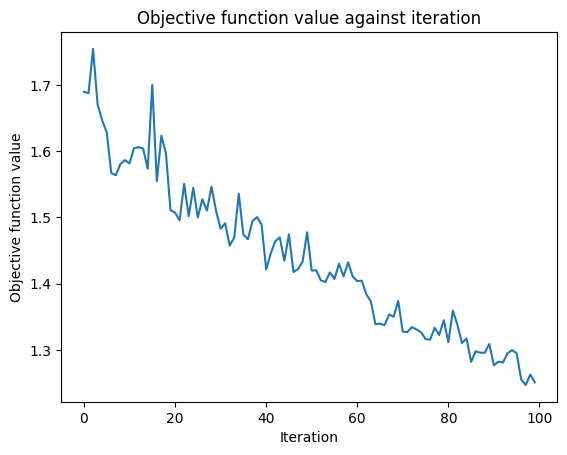

Precision:
 [0.7281576448243116, 0.7396534792368126, 0.691358024691358, 0.8475783475783476, 0.826071169208424, 0.7768389018389018, 0.7231481481481481, 0.9145299145299144, 0.7930021367521367, 0.858974358974359]
Accuracy:
 [0.7222222222222222, 0.7222222222222222, 0.5833333333333334, 0.8055555555555556, 0.6944444444444444, 0.75, 0.6944444444444444, 0.8611111111111112, 0.7222222222222222, 0.8055555555555556]
Recall:
 [0.7083333333333334, 0.7261904761904763, 0.625, 0.8154761904761904, 0.7202380952380952, 0.75, 0.6666666666666666, 0.8809523809523809, 0.7619047619047619, 0.8333333333333334]
F1:
 [0.7243403534253209, 0.7141028900754302, 0.593088071348941, 0.8146502057613169, 0.7190499194847021, 0.7574765498742109, 0.7056030389363723, 0.8705087505087504, 0.7137566137566138, 0.8069933287324592]
Time:
 [52.816195249557495, 52.510732650756836, 52.81733536720276, 52.360251665115356, 52.5595862865448, 52.17078900337219, 52.21463871002197, 52.171632289886475, 52.5647656917572, 61.878737449645996]


In [15]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 100
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=2)



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)

**Precision:**
 [0.7281576448243116, 0.7396534792368126, 0.691358024691358, 0.8475783475783476, 0.826071169208424, 0.7768389018389018, 0.7231481481481481, 0.9145299145299144, 0.7930021367521367, 0.858974358974359]
**Mean Precision**
0.7899312125782714±0.0675

**Accuracy:**
 [0.7222222222222222, 0.7222222222222222, 0.5833333333333334, 0.8055555555555556, 0.6944444444444444, 0.75, 0.6944444444444444, 0.8611111111111112, 0.7222222222222222, 0.8055555555555556]
**Mean Accuracy**
0.736111111111111±0.07

**Recall:**
 [0.7083333333333334, 0.7261904761904763, 0.625, 0.8154761904761904, 0.7202380952380952, 0.75, 0.6666666666666666, 0.8809523809523809, 0.7619047619047619, 0.8333333333333334]
**Mean Recall**
0.7488095238095237±0.07

**F1:**
 [0.7243403534253209, 0.7141028900754302, 0.593088071348941, 0.8146502057613169, 0.7190499194847021, 0.7574765498742109, 0.7056030389363723, 0.8705087505087504, 0.7137566137566138, 0.8069933287324592]
**Mean F1**
0.7419569721904117±0.07

**Time:**
 [52.816195249557495, 52.510732650756836, 52.81733536720276, 52.360251665115356, 52.5595862865448, 52.17078900337219, 52.21463871002197, 52.171632289886475, 52.5647656917572, 61.878737449645996]
**Mean Time**
53.40646643638611±2.8331891840115353


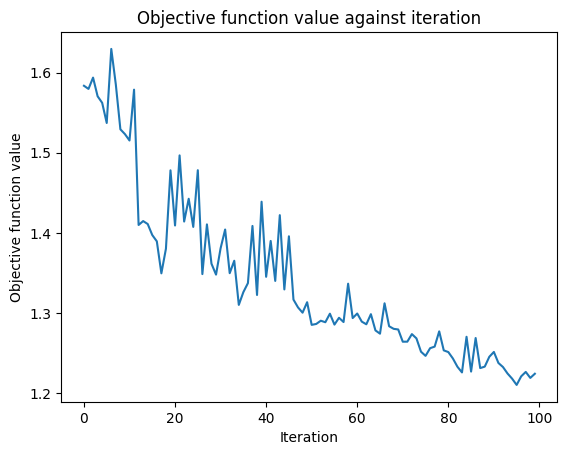

Precision:
 [0.7790775401069517, 0.8391203703703703, 0.8048128342245989, 0.7444919278252612, 0.8529411764705882, 0.7905982905982907, 0.7393162393162394, 0.7133986928104575, 0.861111111111111, 0.8352326685660019]
Accuracy:
 [0.75, 0.8333333333333334, 0.75, 0.7222222222222222, 0.8333333333333334, 0.7222222222222222, 0.7222222222222222, 0.7222222222222222, 0.8333333333333334, 0.8333333333333334]
Recall:
 [0.7678571428571429, 0.8214285714285715, 0.7678571428571428, 0.6904761904761904, 0.8035714285714285, 0.7261904761904763, 0.7083333333333334, 0.6726190476190476, 0.8571428571428571, 0.8392857142857143]
F1:
 [0.7373823120851983, 0.8327635327635328, 0.7476462417039667, 0.720985675846787, 0.8304383788254756, 0.7391240446796002, 0.7283950617283951, 0.7091949269368624, 0.8358974358974359, 0.8332122972645848]
Time:
 [76.32098650932312, 75.27909421920776, 75.73418712615967, 75.87146735191345, 76.82432293891907, 77.38650250434875, 76.24178504943848, 75.9535825252533, 76.1426293849945, 76.709034442

In [16]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 100
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=3)



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)

**Precision:**
 [0.7790775401069517, 0.8391203703703703, 0.8048128342245989, 0.7444919278252612, 0.8529411764705882, 0.7905982905982907, 0.7393162393162394, 0.7133986928104575, 0.861111111111111, 0.8352326685660019]
**Mean Precision**
0.7960100851399871±0.049

**Accuracy:**
 [0.75, 0.8333333333333334, 0.75, 0.7222222222222222, 0.8333333333333334, 0.7222222222222222, 0.7222222222222222, 0.7222222222222222, 0.8333333333333334, 0.8333333333333334]
**Mean Accuracy**
0.7722222222222221±0.05

**Recall:**
 [0.7678571428571429, 0.8214285714285715, 0.7678571428571428, 0.6904761904761904, 0.8035714285714285, 0.7261904761904763, 0.7083333333333334, 0.6726190476190476, 0.8571428571428571, 0.8392857142857143]
**Mean Recall**
0.7654761904761904±0.061

**F1:**
 [0.7373823120851983, 0.8327635327635328, 0.7476462417039667, 0.720985675846787, 0.8304383788254756, 0.7391240446796002, 0.7283950617283951, 0.7091949269368624, 0.8358974358974359, 0.8332122972645848]
**Mean F1**
0.7715039907731838±0.051

**Time:**
 [76.32098650932312, 75.27909421920776, 75.73418712615967, 75.87146735191345, 76.82432293891907, 77.38650250434875, 76.24178504943848, 75.9535825252533, 76.1426293849945, 76.70903444290161]
**Mean Time**
76.24635920524597±0.5734606443643983



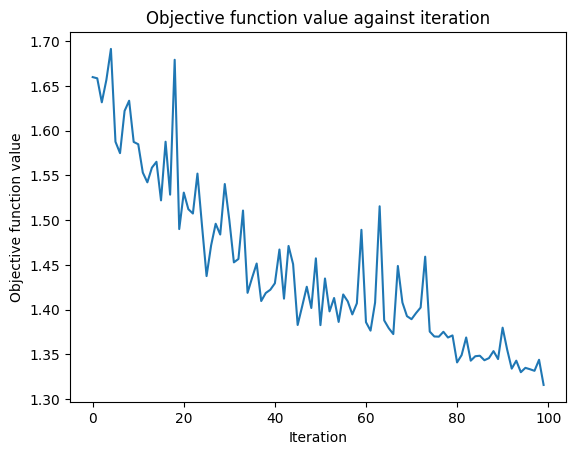

Precision:
 [0.7942760942760942, 0.6715399610136452, 0.7627314814814814, 0.7833333333333333, 0.7000000000000001, 0.7583333333333333, 0.7671156004489338, 0.8962962962962963, 0.7374465811965812, 0.7953897953897954]
Accuracy:
 [0.7777777777777778, 0.6666666666666666, 0.75, 0.7777777777777778, 0.5833333333333334, 0.6666666666666666, 0.6944444444444444, 0.8055555555555556, 0.6944444444444444, 0.7777777777777778]
Recall:
 [0.7916666666666666, 0.6071428571428571, 0.7321428571428571, 0.7738095238095237, 0.625, 0.6964285714285715, 0.7380952380952381, 0.8333333333333334, 0.7380952380952381, 0.8095238095238096]
F1:
 [0.7789697743720733, 0.6414141414141414, 0.7531339031339032, 0.7778471247031086, 0.5831584207896052, 0.6805555555555556, 0.6959742351046699, 0.8119032515167781, 0.6767195767195767, 0.7746502057613169]
Time:
 [86.75473022460938, 71.71454548835754, 67.17946887016296, 66.76259326934814, 67.61312699317932, 67.66738533973694, 67.39995288848877, 67.85497641563416, 67.81648087501526, 67.6350

In [17]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 100
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=4)



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)

**Precision:**
 [0.7942760942760942, 0.6715399610136452, 0.7627314814814814, 0.7833333333333333, 0.7000000000000001, 0.7583333333333333, 0.7671156004489338, 0.8962962962962963, 0.7374465811965812, 0.7953897953897954]
**Mean Precision**
0.7666462476769494±0.0575

**Accuracy:**
 [0.7777777777777778, 0.6666666666666666, 0.75, 0.7777777777777778, 0.5833333333333334, 0.6666666666666666, 0.6944444444444444, 0.8055555555555556, 0.6944444444444444, 0.7777777777777778]
**Mean Accuracy**
0.7194444444444444±0.066

**Recall:**
 [0.7916666666666666, 0.6071428571428571, 0.7321428571428571, 0.7738095238095237, 0.625, 0.6964285714285715, 0.7380952380952381, 0.8333333333333334, 0.7380952380952381, 0.8095238095238096]
**Mean Recall**
0.7345238095238095±0.07

**F1:**
 [0.7789697743720733, 0.6414141414141414, 0.7531339031339032, 0.7778471247031086, 0.5831584207896052, 0.6805555555555556, 0.6959742351046699, 0.8119032515167781, 0.6767195767195767, 0.7746502057613169]
**Mean F1**
0.7174326189070729±0.069

**Time:**
 [86.75473022460938, 71.71454548835754, 67.17946887016296, 66.76259326934814, 67.61312699317932, 67.66738533973694, 67.39995288848877, 67.85497641563416, 67.81648087501526, 67.63500785827637]
**Mean Time**
69.83982682228088±5.785333728659437



# **EfficientSU2 TwoLocal**

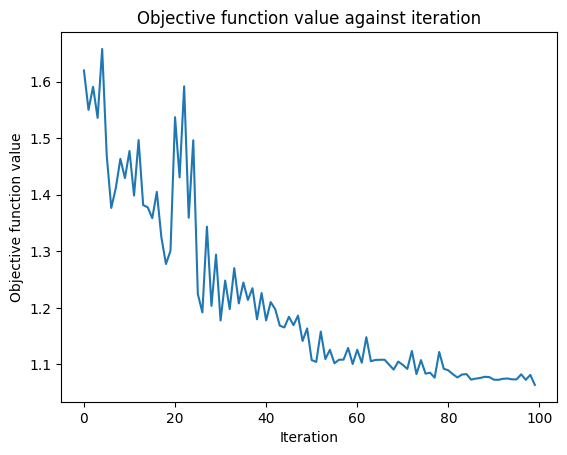

Precision:
 [0.9145299145299144, 0.8796296296296297, 0.8791763791763791, 0.8814814814814815, 0.9145299145299144, 0.9094794094794094, 0.9393939393939394, 0.9145299145299144, 0.8925925925925926, 0.9047619047619047]
Accuracy:
 [0.8611111111111112, 0.8333333333333334, 0.8333333333333334, 0.8611111111111112, 0.8611111111111112, 0.8888888888888888, 0.9166666666666666, 0.8611111111111112, 0.8888888888888888, 0.8333333333333334]
Recall:
 [0.8809523809523809, 0.8392857142857143, 0.8571428571428571, 0.8630952380952381, 0.8809523809523809, 0.9047619047619048, 0.9285714285714285, 0.8809523809523809, 0.8690476190476191, 0.8571428571428571]
F1:
 [0.8705087505087504, 0.8407407407407407, 0.8393976393976393, 0.8637207322264794, 0.8705087505087504, 0.8917878742440146, 0.9182456140350878, 0.8705087505087504, 0.8898112672059033, 0.8460606060606062]
Time:
 [59.767016887664795, 59.46497082710266, 60.181538105010986, 60.010112285614014, 60.26585650444031, 60.00543522834778, 60.2920036315918, 60.1013491153717

In [18]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 100
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = TwoLocal(num_qubits=num_qubits, reps=1, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)

**Precision:**
 [0.9145299145299144, 0.8796296296296297, 0.8791763791763791, 0.8814814814814815, 0.9145299145299144, 0.9094794094794094, 0.9393939393939394, 0.9145299145299144, 0.8925925925925926, 0.9047619047619047]
**Mean Precision**
0.9030105080105081±0.018

**Accuracy:**
 [0.8611111111111112, 0.8333333333333334, 0.8333333333333334, 0.8611111111111112, 0.8611111111111112, 0.8888888888888888, 0.9166666666666666, 0.8611111111111112, 0.8888888888888888, 0.8333333333333334]
**Mean Accuracy**
 0.8638888888888889±0.026

**Recall:**
 [0.8809523809523809, 0.8392857142857143, 0.8571428571428571, 0.8630952380952381, 0.8809523809523809, 0.9047619047619048, 0.9285714285714285, 0.8809523809523809, 0.8690476190476191, 0.8571428571428571]
**Mean Recall**
0.8761904761904763±0.024

**F1:**
 [0.8705087505087504, 0.8407407407407407, 0.8393976393976393, 0.8637207322264794, 0.8705087505087504, 0.8917878742440146, 0.9182456140350878, 0.8705087505087504, 0.8898112672059033, 0.8460606060606062]
**Mean F1**
0.8701290725436722±0.024


**Time:**
 [59.767016887664795, 59.46497082710266, 60.181538105010986, 60.010112285614014, 60.26585650444031, 60.00543522834778, 60.2920036315918, 60.101349115371704, 60.44071912765503, 59.92348575592041]
**Mean Time**
60.04524874687195±0.2682267628666144


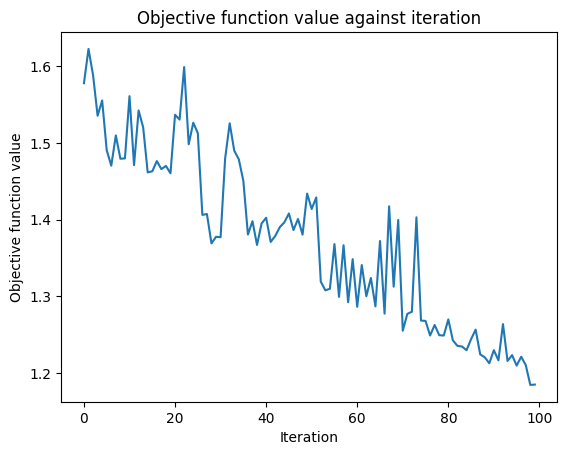

Precision:
 [0.8821225071225071, 0.9145299145299144, 0.8105413105413105, 0.8176638176638177, 0.8425925925925926, 0.8518518518518519, 0.8189542483660132, 0.8888888888888888, 0.7585130918464252, 0.8888888888888888]
Accuracy:
 [0.8333333333333334, 0.8611111111111112, 0.8055555555555556, 0.7777777777777778, 0.8055555555555556, 0.8055555555555556, 0.7777777777777778, 0.8888888888888888, 0.7222222222222222, 0.8888888888888888]
Recall:
 [0.8571428571428571, 0.8809523809523809, 0.7976190476190476, 0.7916666666666666, 0.8333333333333334, 0.8154761904761904, 0.7916666666666666, 0.8690476190476191, 0.7619047619047619, 0.8690476190476191]
F1:
 [0.8405942205942206, 0.8705087505087504, 0.8070685064149116, 0.7858436213991771, 0.8074074074074074, 0.8129629629629629, 0.7782626010770003, 0.8888888888888888, 0.7152035654451113, 0.8888888888888888]
Time:
 [77.82895827293396, 77.63202929496765, 77.3433108329773, 77.90164709091187, 78.07630014419556, 77.8449878692627, 77.91283655166626, 77.39677476882935, 7

In [19]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 100
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = TwoLocal(num_qubits=num_qubits, reps=2, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)

**Precision:**
 [0.8821225071225071, 0.9145299145299144, 0.8105413105413105, 0.8176638176638177, 0.8425925925925926, 0.8518518518518519, 0.8189542483660132, 0.8888888888888888, 0.7585130918464252, 0.8888888888888888]
**Mean Precision:**
0.847454711229221±0.045

**Accuracy:**
 [0.8333333333333334, 0.8611111111111112, 0.8055555555555556, 0.7777777777777778, 0.8055555555555556, 0.8055555555555556, 0.7777777777777778, 0.8888888888888888, 0.7222222222222222, 0.8888888888888888]
**Mean Accuracy:**
0.8166666666666667±0.05

**Recall:**
 [0.8571428571428571, 0.8809523809523809, 0.7976190476190476, 0.7916666666666666, 0.8333333333333334, 0.8154761904761904, 0.7916666666666666, 0.8690476190476191, 0.7619047619047619, 0.8690476190476191]
**Mean Recall:**
 0.8267857142857142±0.04

**F1:**
 [0.8405942205942206, 0.8705087505087504, 0.8070685064149116, 0.7858436213991771, 0.8074074074074074, 0.8129629629629629, 0.7782626010770003, 0.8888888888888888, 0.7152035654451113, 0.8888888888888888]
**Mean F1:**
0.819562941358732±0.052


**Time:**
 [77.82895827293396, 77.63202929496765, 77.3433108329773, 77.90164709091187, 78.07630014419556, 77.8449878692627, 77.91283655166626, 77.39677476882935, 78.09191107749939, 78.2254798412323]
**Mean Time:**
77.82542357444763±0.2759383643642067


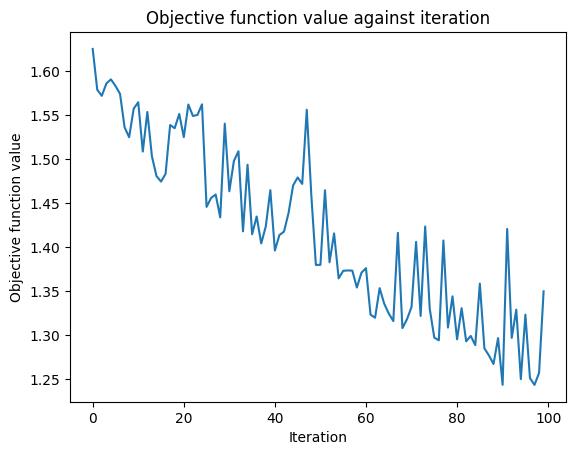

Precision:
 [0.8175925925925925, 0.8907828282828283, 0.8735042735042735, 0.7917228969860548, 0.9094794094794094, 0.7731718898385566, 0.7986704653371319, 0.8484848484848485, 0.8214285714285714, 0.7038027332144979]
Accuracy:
 [0.8055555555555556, 0.8611111111111112, 0.8611111111111112, 0.7777777777777778, 0.8888888888888888, 0.7777777777777778, 0.75, 0.8333333333333334, 0.75, 0.6944444444444444]
Recall:
 [0.8154761904761904, 0.8809523809523809, 0.8630952380952381, 0.7202380952380952, 0.9047619047619048, 0.7202380952380952, 0.7678571428571428, 0.8571428571428571, 0.7857142857142857, 0.6666666666666666]
F1:
 [0.8074548907882241, 0.8544452919738961, 0.8641975308641975, 0.7631874298540965, 0.8917878742440146, 0.7642153371320038, 0.7520128824476652, 0.8315789473684211, 0.75, 0.6921863799283154]
Time:
 [96.56821393966675, 96.4516954421997, 96.15842151641846, 95.75907683372498, 95.90370082855225, 96.34914994239807, 96.80658507347107, 96.62062525749207, 117.39056491851807, 122.12983393669128]


In [20]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 100
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = TwoLocal(num_qubits=num_qubits, reps=3, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)

**Precision:**
 [0.8175925925925925, 0.8907828282828283, 0.8735042735042735, 0.7917228969860548, 0.9094794094794094, 0.7731718898385566, 0.7986704653371319, 0.8484848484848485, 0.8214285714285714, 0.7038027332144979]
**Mean Precision:**
0.8228640509148765±0.058

**Accuracy:**
 [0.8055555555555556, 0.8611111111111112, 0.8611111111111112, 0.7777777777777778, 0.8888888888888888, 0.7777777777777778, 0.75, 0.8333333333333334, 0.75, 0.6944444444444444]
**Mean Accuracy:**
0.8±0.058

**Recall:**
 [0.8154761904761904, 0.8809523809523809, 0.8630952380952381, 0.7202380952380952, 0.9047619047619048, 0.7202380952380952, 0.7678571428571428, 0.8571428571428571, 0.7857142857142857, 0.6666666666666666]
**Mean Recall:**
 0.7982142857142858±0.075

**F1:**
 [0.8074548907882241, 0.8544452919738961, 0.8641975308641975, 0.7631874298540965, 0.8917878742440146, 0.7642153371320038, 0.7520128824476652, 0.8315789473684211, 0.75, 0.6921863799283154]
**Mean F1:**
0.7971066564600834±0.06

**Time:**
 [96.56821393966675, 96.4516954421997, 96.15842151641846, 95.75907683372498, 95.90370082855225, 96.34914994239807, 96.80658507347107, 96.62062525749207, 117.39056491851807, 122.12983393669128]
**Mean Time:**
 101.01378676891326±9.43780103126481



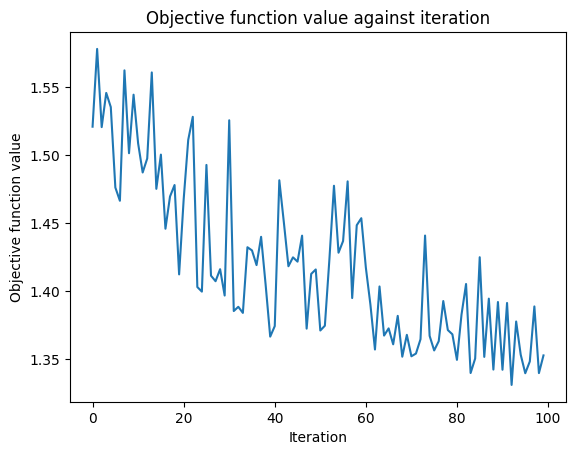

Precision:
 [0.6944444444444444, 0.766025641025641, 0.7210826210826211, 0.7569444444444444, 0.6919191919191919, 0.7885802469135803, 0.8016835016835017, 0.7763979665940449, 0.7751322751322751, 0.7899167109693426]
Accuracy:
 [0.6944444444444444, 0.6666666666666666, 0.7222222222222222, 0.6944444444444444, 0.6944444444444444, 0.6944444444444444, 0.7777777777777778, 0.75, 0.75, 0.7777777777777778]
Recall:
 [0.7023809523809524, 0.6607142857142857, 0.7261904761904763, 0.7202380952380952, 0.7023809523809524, 0.7202380952380952, 0.7559523809523809, 0.75, 0.7142857142857143, 0.7559523809523809]
F1:
 [0.6944444444444444, 0.6761904761904761, 0.7209450830140485, 0.6944444444444443, 0.687765006385696, 0.7085668276972625, 0.7832269050659855, 0.744844423666303, 0.7524074074074074, 0.7686964886964888]
Time:
 [142.35497736930847, 145.1288182735443, 140.86143016815186, 143.75081253051758, 147.48146152496338, 113.99957036972046, 113.74943017959595, 113.31708788871765, 113.72081542015076, 112.7892441749572

In [21]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 100
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = TwoLocal(num_qubits=num_qubits, reps=4, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)

**Precision:**
 [0.6944444444444444, 0.766025641025641, 0.7210826210826211, 0.7569444444444444, 0.6919191919191919, 0.7885802469135803, 0.8016835016835017, 0.7763979665940449, 0.7751322751322751, 0.7899167109693426]
**Mean Precision:**
 0.7562127044209087±0.038

**Accuracy:**
 [0.6944444444444444, 0.6666666666666666, 0.7222222222222222, 0.6944444444444444, 0.6944444444444444, 0.6944444444444444, 0.7777777777777778, 0.75, 0.75, 0.7777777777777778]
**Mean Accuracy:**
 0.7222222222222222±0.037

**Recall:**
 [0.7023809523809524, 0.6607142857142857, 0.7261904761904763, 0.7202380952380952, 0.7023809523809524, 0.7202380952380952, 0.7559523809523809, 0.75, 0.7142857142857143, 0.7559523809523809]
**Mean Recall:**
0.7208333333333334±0.028

**F1:**
 [0.6944444444444444, 0.6761904761904761, 0.7209450830140485, 0.6944444444444443, 0.687765006385696, 0.7085668276972625, 0.7832269050659855, 0.744844423666303, 0.7524074074074074, 0.7686964886964888]
**Mean F1:**
0.7231531507012556±0.035

**Time:**
 [142.35497736930847, 145.1288182735443, 140.86143016815186, 143.75081253051758, 147.48146152496338, 113.99957036972046, 113.74943017959595, 113.31708788871765, 113.72081542015076, 112.78924417495728]
**Mean Time:**
128.71536478996276±15.288286465544141


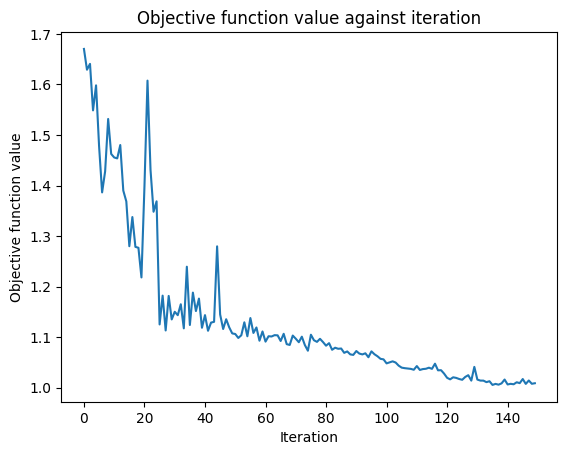

Precision:
 [0.9393939393939394, 0.9094794094794094, 0.9145299145299144, 0.8498316498316498, 0.896011396011396, 0.9145299145299144, 0.8892773892773893, 0.875, 0.8846153846153846, 0.8892773892773893]
Accuracy:
 [0.9166666666666666, 0.8888888888888888, 0.8611111111111112, 0.8333333333333334, 0.8611111111111112, 0.8611111111111112, 0.8611111111111112, 0.8333333333333334, 0.8333333333333334, 0.8611111111111112]
Recall:
 [0.9285714285714285, 0.9047619047619048, 0.8809523809523809, 0.8214285714285715, 0.8809523809523809, 0.8809523809523809, 0.8630952380952381, 0.8392857142857143, 0.8571428571428571, 0.8630952380952381]
F1:
 [0.9205944586061546, 0.8917878742440146, 0.8705087505087504, 0.8347381864623243, 0.8656790123456789, 0.8705087505087504, 0.8683960613785175, 0.8435897435897436, 0.8390652557319224, 0.8683960613785175]
Time:
 [90.3340094089508, 89.91742515563965, 89.99252820014954, 90.1663887500763, 90.43863296508789, 90.13065075874329, 90.56057071685791, 90.13167238235474, 90.221441507339

In [22]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 150
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = TwoLocal(num_qubits=num_qubits, reps=1, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)

**Precision:**
 [0.9393939393939394, 0.9094794094794094, 0.9145299145299144, 0.8498316498316498, 0.896011396011396, 0.9145299145299144, 0.8892773892773893, 0.875, 0.8846153846153846, 0.8892773892773893]
**Mean Precision:**
0.8961946386946386±0.023

**Accuracy:**
 [0.9166666666666666, 0.8888888888888888, 0.8611111111111112, 0.8333333333333334, 0.8611111111111112, 0.8611111111111112, 0.8611111111111112, 0.8333333333333334, 0.8333333333333334, 0.8611111111111112]
**Mean Accuracy:**
0.861111111111111±0.025

**Recall:**
 [0.9285714285714285, 0.9047619047619048, 0.8809523809523809, 0.8214285714285715, 0.8809523809523809, 0.8809523809523809, 0.8630952380952381, 0.8392857142857143, 0.8571428571428571, 0.8630952380952381]
**Mean Recall:**
0.8720238095238095±0.029

**F1:**
 [0.9205944586061546, 0.8917878742440146, 0.8705087505087504, 0.8347381864623243, 0.8656790123456789, 0.8705087505087504, 0.8683960613785175, 0.8435897435897436, 0.8390652557319224, 0.8683960613785175]
**Mean F1:**
0.8673264154754374±0.024

**Time:**
 [90.3340094089508, 89.91742515563965, 89.99252820014954, 90.1663887500763, 90.43863296508789, 90.13065075874329, 90.56057071685791, 90.13167238235474, 90.22144150733948, 90.00642323493958]
**Mean Time:**
90.18997430801392±0.19373765764443432


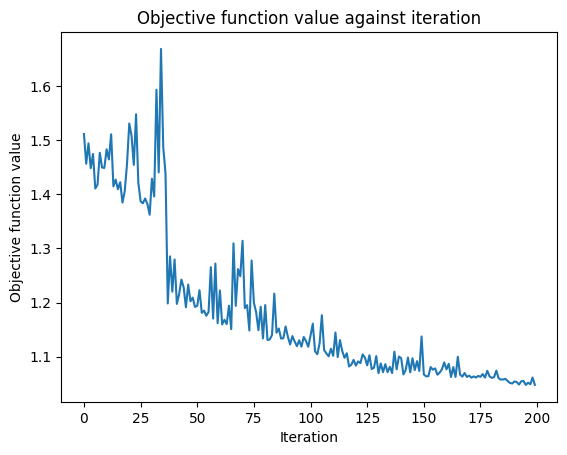

Precision:
 [0.8929249762583097, 0.925925925925926, 0.8635912698412699, 0.9555555555555555, 0.9163817663817664, 0.9047619047619047, 0.9203703703703704, 0.925925925925926, 0.9163817663817664, 0.9555555555555555]
Accuracy:
 [0.8888888888888888, 0.8888888888888888, 0.8611111111111112, 0.9444444444444444, 0.9166666666666666, 0.8333333333333334, 0.9166666666666666, 0.8888888888888888, 0.9166666666666666, 0.9444444444444444]
Recall:
 [0.8869047619047619, 0.9047619047619048, 0.8273809523809524, 0.9523809523809524, 0.9107142857142857, 0.8571428571428571, 0.9107142857142857, 0.9047619047619048, 0.9107142857142857, 0.9523809523809524]
F1:
 [0.8897966594045025, 0.8957264957264957, 0.859670781893004, 0.9465020576131687, 0.9156023839931886, 0.8446645946645945, 0.9175890449836811, 0.8957264957264957, 0.9156023839931886, 0.9465020576131687]
Time:
 [156.49138951301575, 155.3300166130066, 155.79430890083313, 155.23074793815613, 191.48892283439636, 200.82042741775513, 199.38114023208618, 199.00273489952

In [23]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 200
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = TwoLocal(num_qubits=num_qubits, reps=2, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)

**Precision:**
 [0.8929249762583097, 0.925925925925926, 0.8635912698412699, 0.9555555555555555, 0.9163817663817664, 0.9047619047619047, 0.9203703703703704, 0.925925925925926, 0.9163817663817664, 0.9555555555555555]
**Mean Precision:**
0.9177375016958351±0.026

**Accuracy:**
 [0.8888888888888888, 0.8888888888888888, 0.8611111111111112, 0.9444444444444444, 0.9166666666666666, 0.8333333333333334, 0.9166666666666666, 0.8888888888888888, 0.9166666666666666, 0.9444444444444444]
**Mean Accuracy:**
0.9±0.033

**Recall:**
 [0.8869047619047619, 0.9047619047619048, 0.8273809523809524, 0.9523809523809524, 0.9107142857142857, 0.8571428571428571, 0.9107142857142857, 0.9047619047619048, 0.9107142857142857, 0.9523809523809524]
**Mean Recall:**
0.9017857142857142±0.036

**F1:**
 [0.8897966594045025, 0.8957264957264957, 0.859670781893004, 0.9465020576131687, 0.9156023839931886, 0.8446645946645945, 0.9175890449836811, 0.8957264957264957, 0.9156023839931886, 0.9465020576131687]
**Mean F1**
0.9027382955611488±0.031

**Time:**
 [156.49138951301575, 155.3300166130066, 155.79430890083313, 155.23074793815613, 191.48892283439636, 200.82042741775513, 199.38114023208618, 199.00273489952087, 201.45121335983276, 202.8497440814972]
**Mean Time:**
181.78406457901002±21.478707474433612



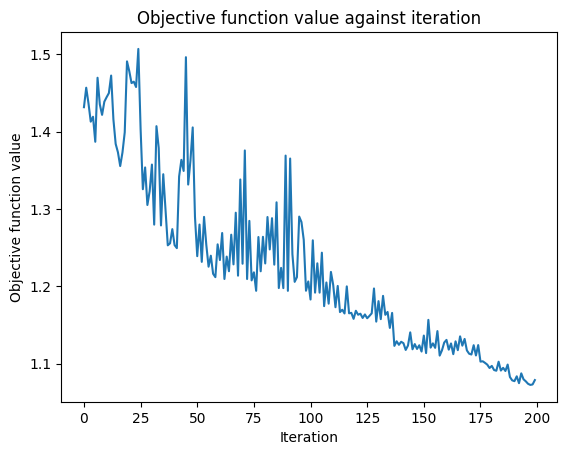

Precision:
 [0.8892773892773893, 0.9393939393939394, 0.8564814814814814, 0.8682336182336182, 0.8500000000000001, 0.9246913580246914, 0.9256410256410257, 0.9094794094794094, 0.71476453829395, 0.925925925925926]
Accuracy:
 [0.8611111111111112, 0.9166666666666666, 0.7777777777777778, 0.8611111111111112, 0.8333333333333334, 0.9166666666666666, 0.9166666666666666, 0.8888888888888888, 0.7222222222222222, 0.8888888888888888]
Recall:
 [0.8630952380952381, 0.9285714285714285, 0.7916666666666666, 0.8452380952380952, 0.8392857142857143, 0.9107142857142857, 0.9285714285714285, 0.9047619047619048, 0.6904761904761906, 0.9047619047619048]
F1:
 [0.8683960613785175, 0.9205944586061546, 0.7945480445480445, 0.8636528685548294, 0.8373694207027539, 0.9174598221251364, 0.9176954732510288, 0.8917878742440146, 0.7124082607953576, 0.8957264957264957]
Time:
 [249.6665449142456, 246.4471173286438, 244.6191051006317, 249.34004735946655, 252.51988863945007, 244.7626757621765, 195.51367473602295, 194.59669399261475

In [25]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 200
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = TwoLocal(num_qubits=num_qubits, reps=3, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)

**Precision:**
 [0.8892773892773893, 0.9393939393939394, 0.8564814814814814, 0.8682336182336182, 0.8500000000000001, 0.9246913580246914, 0.9256410256410257, 0.9094794094794094, 0.71476453829395, 0.925925925925926]
**Mean Precision:**
0.8803888685751431±0.062

**Accuracy:**
 [0.8611111111111112, 0.9166666666666666, 0.7777777777777778, 0.8611111111111112, 0.8333333333333334, 0.9166666666666666, 0.9166666666666666, 0.8888888888888888, 0.7222222222222222, 0.8888888888888888]
**Mean Accuracy:**
0.8583333333333332±0.061

**Recall:**
 [0.8630952380952381, 0.9285714285714285, 0.7916666666666666, 0.8452380952380952, 0.8392857142857143, 0.9107142857142857, 0.9285714285714285, 0.9047619047619048, 0.6904761904761906, 0.9047619047619048]
**Mean Recall:**
0.8607142857142855±0.07

**F1:**
 [0.8683960613785175, 0.9205944586061546, 0.7945480445480445, 0.8636528685548294, 0.8373694207027539, 0.9174598221251364, 0.9176954732510288, 0.8917878742440146, 0.7124082607953576, 0.8957264957264957]
**Mean F1:**
0.8619638779932334±0.06

**Time:**
 [249.6665449142456, 246.4471173286438, 244.6191051006317, 249.34004735946655, 252.51988863945007, 244.7626757621765, 195.51367473602295, 194.59669399261475, 194.86786794662476, 195.14848279953003]
**Mean Time:**
226.74820985794068±25.9922537923594



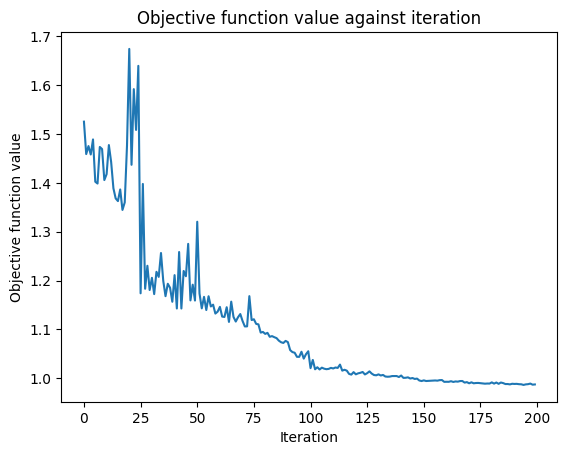

Precision:
 [0.9034188034188033, 0.9176163342830009, 0.925925925925926, 0.8892773892773893, 0.925925925925926, 0.9228395061728395, 0.8929249762583097, 0.9555555555555555, 0.9145299145299144, 0.9047619047619047]
Accuracy:
 [0.8888888888888888, 0.9166666666666666, 0.8888888888888888, 0.8611111111111112, 0.8888888888888888, 0.9166666666666666, 0.8888888888888888, 0.9444444444444444, 0.8611111111111112, 0.8333333333333334]
Recall:
 [0.8869047619047619, 0.9285714285714285, 0.9047619047619048, 0.8630952380952381, 0.9047619047619048, 0.9107142857142857, 0.8869047619047619, 0.9523809523809524, 0.8809523809523809, 0.8571428571428571]
F1:
 [0.8930041152263376, 0.9159404502541757, 0.8957264957264957, 0.8683960613785175, 0.8944855967078189, 0.9186032437666424, 0.8897966594045025, 0.9465020576131687, 0.8705087505087504, 0.8460606060606062]
Time:
 [121.55064988136292, 122.79406714439392, 122.11337304115295, 122.25503087043762, 123.30447506904602, 123.73043942451477, 122.57032346725464, 122.549010753

In [26]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 200
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = TwoLocal(num_qubits=num_qubits, reps=1, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)

**Precision:**
 [0.9034188034188033, 0.9176163342830009, 0.925925925925926, 0.8892773892773893, 0.925925925925926, 0.9228395061728395, 0.8929249762583097, 0.9555555555555555, 0.9145299145299144, 0.9047619047619047]
**Mean Precision:**
0.915277623610957±0.018

**Accuracy:**
 [0.8888888888888888, 0.9166666666666666, 0.8888888888888888, 0.8611111111111112, 0.8888888888888888, 0.9166666666666666, 0.8888888888888888, 0.9444444444444444, 0.8611111111111112, 0.8333333333333334]
**Mean Accuracy:**
0.888888888888889±0.03

**Recall:**
 [0.8869047619047619, 0.9285714285714285, 0.9047619047619048, 0.8630952380952381, 0.9047619047619048, 0.9107142857142857, 0.8869047619047619, 0.9523809523809524, 0.8809523809523809, 0.8571428571428571]
**Mean Recall:**
0.8976190476190476±0.0275

**F1:**
 [0.8930041152263376, 0.9159404502541757, 0.8957264957264957, 0.8683960613785175, 0.8944855967078189, 0.9186032437666424, 0.8897966594045025, 0.9465020576131687, 0.8705087505087504, 0.8460606060606062]
**Mean F1:**
 0.8939024036647016±0.027
 
**Time:**
 [121.55064988136292, 122.79406714439392, 122.11337304115295, 122.25503087043762, 123.30447506904602, 123.73043942451477, 122.57032346725464, 122.54901075363159, 122.69259524345398, 123.02915096282959]
**Mean Time:**
122.6589115858078±0.5856880500124855


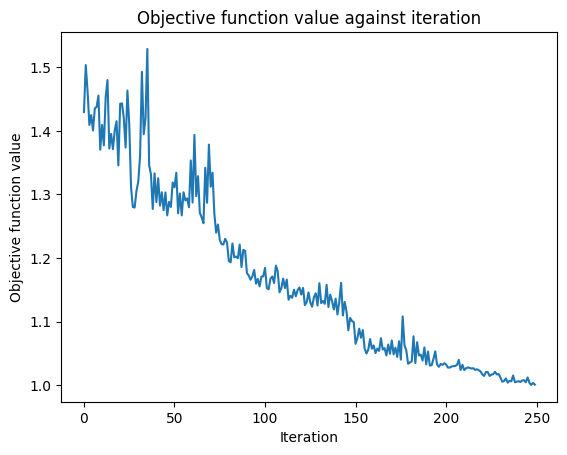

Precision:
 [0.9228395061728395, 0.9055555555555556, 0.875, 0.8888888888888888, 0.9055555555555556, 0.9555555555555555, 0.925925925925926, 0.8362745098039215, 0.8611111111111112, 0.974074074074074]
Accuracy:
 [0.9166666666666666, 0.8888888888888888, 0.8333333333333334, 0.8888888888888888, 0.8888888888888888, 0.9444444444444444, 0.8888888888888888, 0.8333333333333334, 0.8611111111111112, 0.9722222222222222]
Recall:
 [0.9107142857142857, 0.8869047619047619, 0.8392857142857143, 0.8690476190476191, 0.8869047619047619, 0.9523809523809524, 0.9047619047619048, 0.7857142857142857, 0.8452380952380952, 0.9761904761904763]
F1:
 [0.9186032437666424, 0.8929249762583095, 0.8435897435897436, 0.8888888888888888, 0.8929249762583095, 0.9465020576131687, 0.8907407407407406, 0.8240281224152192, 0.8611111111111112, 0.9721867461331064]
Time:
 [196.59727787971497, 196.487366437912, 195.97952008247375, 195.34839916229248, 199.39869379997253, 195.49999165534973, 195.380389213562, 196.0047583580017, 196.5571174

In [27]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 250
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = TwoLocal(num_qubits=num_qubits, reps=2, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)

**Precision:**
 [0.9228395061728395, 0.9055555555555556, 0.875, 0.8888888888888888, 0.9055555555555556, 0.9555555555555555, 0.925925925925926, 0.8362745098039215, 0.8611111111111112, 0.974074074074074]
**Mean Precision:**
0.9050780682643428±0.04

**Accuracy:**
 [0.9166666666666666, 0.8888888888888888, 0.8333333333333334, 0.8888888888888888, 0.8888888888888888, 0.9444444444444444, 0.8888888888888888, 0.8333333333333334, 0.8611111111111112, 0.9722222222222222]
**Mean Accuracy:**
0.8916666666666666±0.042

**Recall:**
 [0.9107142857142857, 0.8869047619047619, 0.8392857142857143, 0.8690476190476191, 0.8869047619047619, 0.9523809523809524, 0.9047619047619048, 0.7857142857142857, 0.8452380952380952, 0.9761904761904763]
**Mean Recall:**
0.8857142857142858±0.053

**F1:**
 [0.9186032437666424, 0.8929249762583095, 0.8435897435897436, 0.8888888888888888, 0.8929249762583095, 0.9465020576131687, 0.8907407407407406, 0.8240281224152192, 0.8611111111111112, 0.9721867461331064]
**Mean F1:**
0.893150060677524±0.042

**Time:**
 [196.59727787971497, 196.487366437912, 195.97952008247375, 195.34839916229248, 199.39869379997253, 195.49999165534973, 195.380389213562, 196.0047583580017, 196.5571174621582, 196.0951793193817]
**Mean Time:**
196.3348693370819±1.1136607332917174


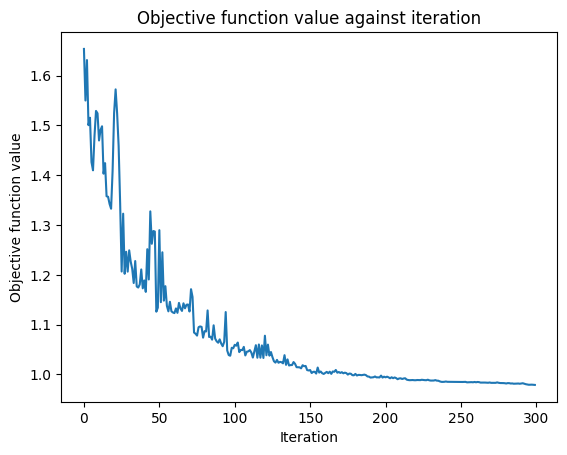

Precision:
 [0.9393939393939394, 0.9393939393939394, 0.9393939393939394, 0.9393939393939394, 0.9145299145299144, 0.925925925925926, 0.9166666666666666, 0.925925925925926, 0.925925925925926, 0.9034188034188033]
Accuracy:
 [0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 0.8611111111111112, 0.8888888888888888, 0.9166666666666666, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888]
Recall:
 [0.9285714285714285, 0.9285714285714285, 0.9285714285714285, 0.9285714285714285, 0.8809523809523809, 0.9047619047619048, 0.9107142857142857, 0.9047619047619048, 0.9047619047619048, 0.8869047619047619]
F1:
 [0.9205944586061546, 0.9205944586061546, 0.9205944586061546, 0.9205944586061546, 0.8705087505087504, 0.8944855967078189, 0.9166666666666666, 0.8944855967078189, 0.8944855967078189, 0.8930041152263376]
Time:
 [183.14595007896423, 182.80808973312378, 183.73312878608704, 211.62290358543396, 231.75868821144104, 236.88856625556946, 236.1688630580902, 210.71531009674

In [28]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 300
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = TwoLocal(num_qubits=num_qubits, reps=1, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)

**Precision:**
 [0.9393939393939394, 0.9393939393939394, 0.9393939393939394, 0.9393939393939394, 0.9145299145299144, 0.925925925925926, 0.9166666666666666, 0.925925925925926, 0.925925925925926, 0.9034188034188033]
**Mean Precision:**
0.9269968919968921±0.012

**Accuracy:**
 [0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 0.8611111111111112, 0.8888888888888888, 0.9166666666666666, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888]
**Mean Accuracy:**
0.9±0.018

**Recall:**
 [0.9285714285714285, 0.9285714285714285, 0.9285714285714285, 0.9285714285714285, 0.8809523809523809, 0.9047619047619048, 0.9107142857142857, 0.9047619047619048, 0.9047619047619048, 0.8869047619047619]
**Mean Recall:**
0.9107142857142858±0.017

**F1:**
 [0.9205944586061546, 0.9205944586061546, 0.9205944586061546, 0.9205944586061546, 0.8705087505087504, 0.8944855967078189, 0.9166666666666666, 0.8944855967078189, 0.8944855967078189, 0.8930041152263376]
**Mean F1:**
0.9046014156949831±0.017

**Time:**
 [183.14595007896423, 182.80808973312378, 183.73312878608704, 211.62290358543396, 231.75868821144104, 236.88856625556946, 236.1688630580902, 210.71531009674072, 183.46513152122498, 182.97371983528137]
**Mean Time:**
204.32803511619568±22.688512730204067


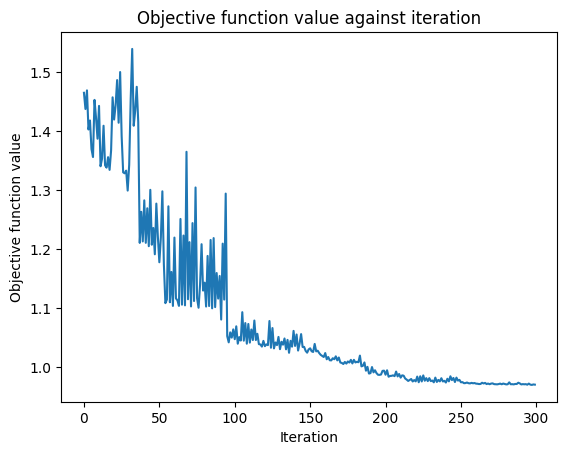

Precision:
 [0.9094794094794094, 0.9166666666666666, 0.7991452991452992, 0.9555555555555555, 0.896011396011396, 0.9009259259259258, 0.925925925925926, 0.9228395061728395, 0.9094794094794094, 0.9555555555555555]
Accuracy:
 [0.8888888888888888, 0.9166666666666666, 0.7777777777777778, 0.9444444444444444, 0.8611111111111112, 0.8888888888888888, 0.8888888888888888, 0.9166666666666666, 0.8888888888888888, 0.9444444444444444]
Recall:
 [0.9047619047619048, 0.9107142857142857, 0.7559523809523809, 0.9523809523809524, 0.8809523809523809, 0.8869047619047619, 0.9047619047619048, 0.9107142857142857, 0.9047619047619048, 0.9523809523809524]
F1:
 [0.8917878742440146, 0.9166666666666666, 0.786008230452675, 0.9465020576131687, 0.8656790123456789, 0.8907882241215574, 0.8957264957264957, 0.9186032437666424, 0.8917878742440146, 0.9465020576131687]
Time:
 [234.9155411720276, 236.34190893173218, 234.95381784439087, 235.53967380523682, 236.25861978530884, 237.01499915122986, 236.06364154815674, 267.45973324775

In [29]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 300
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = TwoLocal(num_qubits=num_qubits, reps=2, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)

**Precision:**
 [0.9094794094794094, 0.9166666666666666, 0.7991452991452992, 0.9555555555555555, 0.896011396011396, 0.9009259259259258, 0.925925925925926, 0.9228395061728395, 0.9094794094794094, 0.9555555555555555]
**Mean Precision:**
0.9091584649917983±0.041

**Accuracy:**
 [0.8888888888888888, 0.9166666666666666, 0.7777777777777778, 0.9444444444444444, 0.8611111111111112, 0.8888888888888888, 0.8888888888888888, 0.9166666666666666, 0.8888888888888888, 0.9444444444444444]
**Mean Accuracy:**
0.8916666666666666±0.046

**Recall:**
 [0.9047619047619048, 0.9107142857142857, 0.7559523809523809, 0.9523809523809524, 0.8809523809523809, 0.8869047619047619, 0.9047619047619048, 0.9107142857142857, 0.9047619047619048, 0.9523809523809524]
**Mean Recall:**
0.8964285714285714±0.052

**F1:**
 [0.8917878742440146, 0.9166666666666666, 0.786008230452675, 0.9465020576131687, 0.8656790123456789, 0.8907882241215574, 0.8957264957264957, 0.9186032437666424, 0.8917878742440146, 0.9465020576131687]
**Mean F1:**
0.8950051736794082±0.044

**Time:**
 [234.9155411720276, 236.34190893173218, 234.95381784439087, 235.53967380523682, 236.25861978530884, 237.01499915122986, 236.06364154815674, 267.45973324775696, 302.3043158054352, 300.0834147930145]
**Mean Time:**
252.09356660842894±26.279902602318625


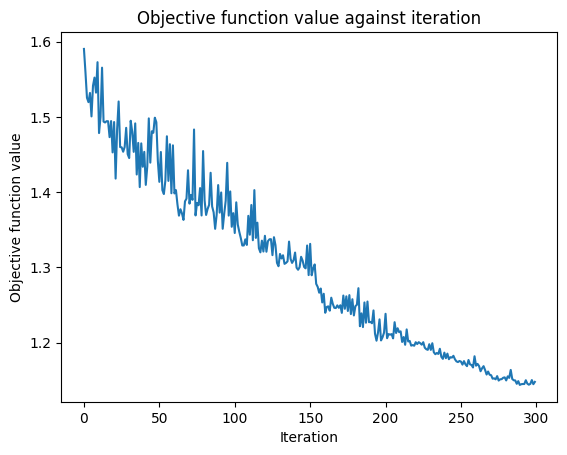

Precision:
 [0.9393939393939394, 0.9555555555555555, 0.925925925925926, 0.9055555555555556, 0.9116161616161617, 0.8914141414141414, 0.974074074074074, 0.9236111111111112, 0.8847222222222223, 0.8244625744625744]
Accuracy:
 [0.9166666666666666, 0.9444444444444444, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8611111111111112, 0.9722222222222222, 0.9166666666666666, 0.8611111111111112, 0.8055555555555556]
Recall:
 [0.9285714285714285, 0.9523809523809524, 0.9047619047619048, 0.8869047619047619, 0.9047619047619048, 0.8630952380952381, 0.9761904761904763, 0.9107142857142857, 0.8630952380952381, 0.8154761904761904]
F1:
 [0.9205944586061546, 0.9465020576131687, 0.8944855967078189, 0.8929249762583095, 0.89046783625731, 0.8670760233918129, 0.9721867461331064, 0.9163817663817664, 0.8598765432098765, 0.8085670015494577]
Time:
 [341.1889729499817, 328.0985631942749, 369.09259366989136, 371.76506638526917, 372.44227623939514, 365.26895356178284, 299.3195288181305, 291.88140630722046

In [30]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 300
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = TwoLocal(num_qubits=num_qubits, reps=3, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)

**Precision:**
 [0.9393939393939394, 0.9555555555555555, 0.925925925925926, 0.9055555555555556, 0.9116161616161617, 0.8914141414141414, 0.974074074074074, 0.9236111111111112, 0.8847222222222223, 0.8244625744625744]
**Mean Precision:**
0.9136331261331261±0.04

**Accuracy:**
 [0.9166666666666666, 0.9444444444444444, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8611111111111112, 0.9722222222222222, 0.9166666666666666, 0.8611111111111112, 0.8055555555555556]
**Mean Accuracy:**
0.8944444444444445±0.044

**Recall:**
 [0.9285714285714285, 0.9523809523809524, 0.9047619047619048, 0.8869047619047619, 0.9047619047619048, 0.8630952380952381, 0.9761904761904763, 0.9107142857142857, 0.8630952380952381, 0.8154761904761904]
**Mean Recall:**
0.900595238095238±0.044

**F1:**
 [0.9205944586061546, 0.9465020576131687, 0.8944855967078189, 0.8929249762583095, 0.89046783625731, 0.8670760233918129, 0.9721867461331064, 0.9163817663817664, 0.8598765432098765, 0.8085670015494577]
**Mean F1:**
 0.8969063006108782±0.044

**Time:**
 [341.1889729499817, 328.0985631942749, 369.09259366989136, 371.76506638526917, 372.44227623939514, 365.26895356178284, 299.3195288181305, 291.88140630722046, 292.1728472709656, 292.1734161376953]
**Mean Time:**
332.34036245346067±34.12901344681647


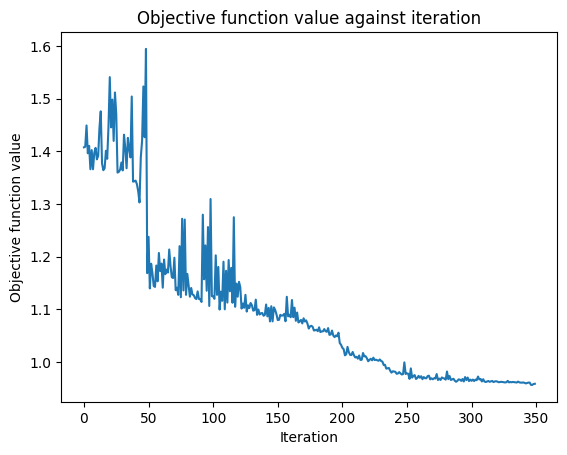

Precision:
 [0.9753086419753088, 0.9145299145299144, 0.9228395061728395, 0.925925925925926, 0.9047619047619047, 0.9034188034188033, 0.9236111111111112, 0.8592592592592593, 0.925925925925926, 0.9393939393939394]
Accuracy:
 [0.9722222222222222, 0.8611111111111112, 0.9166666666666666, 0.8888888888888888, 0.8333333333333334, 0.8888888888888888, 0.9166666666666666, 0.8333333333333334, 0.8888888888888888, 0.9166666666666666]
Recall:
 [0.9761904761904763, 0.8809523809523809, 0.9107142857142857, 0.9047619047619048, 0.8571428571428571, 0.8869047619047619, 0.8928571428571429, 0.8214285714285715, 0.9047619047619048, 0.9285714285714285]
F1:
 [0.9725248123940935, 0.8678718400940624, 0.9186032437666424, 0.8944855967078189, 0.8460606060606062, 0.8930041152263376, 0.9145502645502646, 0.839029374201788, 0.8944855967078189, 0.9182456140350878]
Time:
 [343.91902565956116, 441.6792607307434, 437.2064847946167, 427.67659759521484, 342.0132865905762, 340.8148512840271, 341.67409014701843, 340.7586371898651,

In [31]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 350
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = TwoLocal(num_qubits=num_qubits, reps=3, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)

**Precision:**
 [0.9753086419753088, 0.9145299145299144, 0.9228395061728395, 0.925925925925926, 0.9047619047619047, 0.9034188034188033, 0.9236111111111112, 0.8592592592592593, 0.925925925925926, 0.9393939393939394]
**Mean Precision:**
0.9194974932474931±0.028

**Accuracy:**
 [0.9722222222222222, 0.8611111111111112, 0.9166666666666666, 0.8888888888888888, 0.8333333333333334, 0.8888888888888888, 0.9166666666666666, 0.8333333333333334, 0.8888888888888888, 0.9166666666666666]
**Mean Accuracy:**
0.8916666666666666±0.04

**Recall:**
 [0.9761904761904763, 0.8809523809523809, 0.9107142857142857, 0.9047619047619048, 0.8571428571428571, 0.8869047619047619, 0.8928571428571429, 0.8214285714285715, 0.9047619047619048, 0.9285714285714285]
**Mean Recall:**
0.8964285714285716±0.039

**F1:**
 [0.9725248123940935, 0.8678718400940624, 0.9186032437666424, 0.8944855967078189, 0.8460606060606062, 0.8930041152263376, 0.9145502645502646, 0.839029374201788, 0.8944855967078189, 0.9182456140350878]
**Mean F1:**
0.8958861063744521±0.037

**Time:**
 [343.91902565956116, 441.6792607307434, 437.2064847946167, 427.67659759521484, 342.0132865905762, 340.8148512840271, 341.67409014701843, 340.7586371898651, 378.65614581108093, 454.22248673439026]
**Mean Time:**
384.8620866537094±46.81177051350796
